In [1]:
from __future__ import annotations
from rich import print
from rich.pretty import pprint
from custom_counter import CustomCounter as Counter
from collections import defaultdict, namedtuple
from bitarray import bitarray, frozenbitarray
from bitarray.util import ba2int, int2ba, canonical_huffman, huffman_code,\
    vl_encode, vl_decode, sc_encode, sc_decode, serialize
from sortedcontainers import SortedSet, SortedDict, SortedList, SortedKeyList, SortedListWithKey,\
    SortedKeysView, SortedValuesView, SortedItemsView
from typing import List, Set, Dict, Tuple, Optional, Union, Iterable
from dataclasses import dataclass, field
from enum import Enum, IntEnum
from copy import deepcopy, copy
import operator
import graphviz
from lolviz import *

from hash_range_iterator import DEFAULT_ENDIAN, int_from_nounce, int_bits_from_nounce, last_int_bits_from_nounce,\
    last_ba_bits_from_nounce, last_ba_bits_from_digest, last_fba_bits_from_digest, last_int_bits_from_digest,\
    split_data, count_data_items, create_value_bitmap, collect_missing_positions
from itertools import accumulate
from more_itertools import nth

In [2]:
file_name = './data/AMillionRandomDigits.bin'
#file_name = f"./data/image-144kb.jpg"
data = bitarray(endian=DEFAULT_ENDIAN)
file = open(file=file_name, mode='rb')
data.fromfile(file)

data        = frozenbitarray(data) # first n bits
data_length = len(data)

print(f"file: {file_name},\nsize: {len(data):,} bits,\n      {(len(data) // 8):,} bytes,\n      {len(data) // 8 // 1024} Kb")

file: ./data/AMillionRandomDigits.bin,
size: 3,321,928 bits,
      415,241 bytes,
      405 Kb

In [3]:
item_length = 16
item_counts = count_data_items(data=data, item_length=item_length)

print(f"l={item_counts.aggregated_counts()[0]} f={(item_counts.aggregated_counts()[0]/2**item_length):2.4%}")

pprint(item_counts.aggregated_counts().first_items(), max_length=64)
for ic, ac in item_counts.aggregated_counts().first_items():
    print(f"{ic:2}: {ac:5} ({ac/(2**item_length):2.5%})")

removed last 8 bits: tail=frozenbitarray('01110011')

l=2665 f=4.0665%

[
│   (0, 2665),
│   (1, 8878),
│   (2, 13851),
│   (3, 14650),
│   (4, 11515),
│   (5, 7248),
│   (6, 3893),
│   (7, 1785),
│   (8, 668),
│   (9, 273),
│   (10, 85),
│   (11, 17),
│   (12, 5),
│   (13, 3)
]

0:  2665 (4.06647%)

1:  8878 (13.54675%)

2: 13851 (21.13495%)

3: 14650 (22.35413%)

4: 11515 (17.57050%)

5:  7248 (11.05957%)

6:  3893 (5.94025%)

7:  1785 (2.72369%)

8:   668 (1.01929%)

9:   273 (0.41656%)

10:    85 (0.12970%)

11:    17 (0.02594%)

12:     5 (0.00763%)

13:     3 (0.00458%)

In [4]:
bitmap = create_value_bitmap(item_counts=item_counts, item_length=item_length)
print(len(bitmap), bitmap[0:256])

65536 
bitarray('000001000000000000000000000000000000000000000000001000000000000000000000000000000000001000000000000000000
0000000100000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000
000000000000000000000000000010000000')

In [5]:
sc_encoded_bitmap = sc_encode(bitmap.copy())
print(len(sc_encoded_bitmap)*8, sc_encoded_bitmap[0:256])

23408 
b'\x13\x00\x00\x01\xa6\x052Vp\xba\xf8\xafBSU\\\x81\x84\xa5\xae\xaf\xc2\xc5\xc9\xe7\xec\xf3\xad%)6GNOh|\x9d\x9f\xaa\
xdb\xe4\xa6\x05\x12L}\xa8\xe9\xa7K{\xac\xad\xc0\xd1\xf9\xa45dj\xb2\xa5\x13&>\x8a\x9e\xa9\x14u\x82\xab\xd0\xde\xe5\x
e7\xf1\xac\x18#4AQp{\x83\x9d\xb4\xc9\xfc\xa7\x0b18n\x8e\xa1\xf6\xae\x14]aelm\x80\x8b\x8d\x8f\xa0\xa4\xd7\xed\xae\x1
f)7Bais|\x85\x8d\x93\x95\xa1\xff\xa8\x1a,\x8d\x9e\xa9\xd2\xd4\xfa\xa7\x0b"\\bf\x97\xcf\xae\x02AZ\\lt\x82\x85\xaa\xb
0\xe2\xe7\xe9\xfd\xae\x06#%.8N\x88\xb1\xb8\xcb\xdd\xe1\xed\xfc\xae\n(:E^q{\x8e\xa6\xad\xbc\xce\xd3\xf3\xa7\x06y\x83
\xa3\xac\xe7\xeb\xa7\x08\x1d_g\x9d\xba\xd5\xac\x0e4Ux\x93\x9f\xc4\xc9\xd1\xe3\xf0\xf7\xaa\x0b4\\]wx\x8b\x8d\xc5\xd1
\xaa\x16\x18EZ\x81\x8a\xaa\xae\xb5\xb6\xb1&.@FL{\x88\x8e\x95\xa8\xb3\xcd\xdb\xe2'

In [6]:
vl_encoded_bitmap = vl_encode(bitmap.copy())
print(len(vl_encoded_bitmap)*8, vl_encoded_bitmap[0:256])

74904 
b'\xa0\xa0\x80\x80\x80\x80\x80\x84\x80\x80\x80\x80\x82\x80\x80\x80\x88\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\xc0\
x80\x80\x80\x80\x80\x80\x80\x81\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x88\x80\x81\xa0\xa0\x80\x80\x80\x80\x89\x80
\x80\x80\x80\x84\x81\xc0\x80\x82\xa2\x80\x80\x80\x80\xc2\x82\x80\x80\x80\x80\x80\x80\x81\x88\x80\x90\x80\x82\x83\x8
0\x80\x80\x88\x80\x80\x90\x80\x80\x80\x80\xd0\x81\x80\x80\x80\x80\x80\x80\x81\x80\xa0\x80\x80\x80\x81\x80\x82\x80\x
80\x80\x80\x80\x80\x80\x80\xc0\x80\x80\x80\x80\x80\x80\xc0\x80\x80\x80\x80\x80\xa0\x80\x80\x80\x80\x80\x80\x80\x80\
x88\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x88\x80\x80\x80\x80\x80\x80\x90\x80\x80\x80\x80\x80\x80\x98
\x80\x80\xa0\x80\x84\x80\x80\x80\x80\x80\x90\x80\x80\x80\x80\x80\x80\x80\x81\x80\x80\x80\x80\x80\x80\x84\x88\x80\x8
0\x80\x80\x80\x80\x80\x80\x80\x82\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x84\x80\x80\x90\x80\x80\x82\x
80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x84\x80\x80\x88\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80'

In [7]:
encoded_bitmap = serialize(bitmap.copy())
print(len(encoded_bitmap)*8, encoded_bitmap[0:256])

65544 b'\x10\x04\x00\x00\x00\x00\x00 \x00\x00\x00\x02\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x00\x00 
\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x00\x00 
\x00\x14\x08\x00\x00\x00\x00H\x00\x00\x00\x04\x03\x00\x00$@\x00\x00\x01\x08\x10\x00\x00\x00\x00\x00\x04@\x02\x00\x0
1\x03\x00\x00\x00\x80\x00\x08\x00\x00\x00\x05\x00 \x00\x00\x00\x00\x00\x10\x08\x00\x00\x00\x04\x00 
\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x
00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x0c\x00\x00\x80\x00@\x00\x00\x00
\x00@\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x08 \x00\x00\x00\x00\x00\x00\x00\x00 
\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x02\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00 
\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0
4\x00 \x00\x00\x00\x00\x10\x00\x00\x00\x00\x80\x02\x05\x00@'

In [8]:
from rle_utils import create_rle_spans, encode_rle_spans, encode_rle_data, BitArray
bs_bitmap          = BitArray(bitmap.copy())
rle_encoded_bitmap = bytes(encode_rle_data(data=bs_bitmap))
print(len(rle_encoded_bitmap)*8, rle_encoded_bitmap[0:256], bs_bitmap.tobitarray()[0:256])

45168 b'\x02\x04\x15\x02 \r\x02\x02\r\x02\x80!\x02 \x1d\x02\x80!\x02 
\x05\x04\x14\x08\x11\x02H\r\x04\x04\x03\t\x04$@\t\x06\x01\x08\x10\x15\x06\x04@\x02\x05\x04\x01\x03\r\x02\x80\x05\x0
2\x08\r\x02\x05\x05\x02 \x15\x04\x10\x08\r\x02\x04\x05\x02 
\x19\x02\x08\x15\x02\x04\x15\x02\x80\x1d\x02@-\x02\x10\x15\x02\x10\x15\x02\x0c\t\x02\x80\x05\x02@\x11\x02@\x19\x02\
x04\x15\x04\x08 !\x02 -\x02\x10\x05\x02\x02\t\x02\x02%\x02 \x05\x02\x029\x02\x08-\x02\x04\x05\x02 
\x11\x02\x10\x11\x06\x80\x02\x05\x05\x02@\x11\x04\x80\x10\x05\x02\x08\x05\x02@\x05\x02@\r\x06\x80\x10\x10\t\x02\x04
\t\x02\x08\t\x02@\x15\x02\x08\x05\x02\x10\x11\x04@\x80\x15\x02\x02\r\x02\x02\t\x02@%\x02\x02\r\x02\x08!\x06\x04D\x0
c\t\x04\x80\x15\t\x02\x88\x15\x02\x01\t\x02\x04\x15\x02\x01\x05\x04@\x01\x05\x02 
\r\x0e@@\x10\x08\x04\x04\x14\x05\x02@)\x02\x01\r\x02 \x05\x02\x08-\x02\x04\x05\x02\x02\x05\x02@' 
bitarray('000001000000000000000000000000000000000000000000001000000000000000000000000000000000001000000000000000000
0000000100000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000
000000000000000000000000000010000000')

In [9]:
from delta_of_delta import delta_encode

positions = collect_missing_positions(position_bitmap=bitmap.copy(), item_length=item_length)
print(f"{len(positions)}, {positions[0:64]}")

encoded_positions = delta_encode(positions)
position_deltas   = [encoded_positions.initial_timestamp] + encoded_positions.deltas
print(f"{len(position_deltas)}, {position_deltas[0:32]}, unique: {len(SortedSet(position_deltas))}")

delta_length_counts = Counter()
delta_value_counts  = Counter()

for delta in position_deltas:
    delta_length = delta.bit_length()
    delta_length_counts.update({ delta_length: 1 })
    delta_value_counts.update({ delta: 1 })

pprint(delta_length_counts.first_items())
print(len(delta_value_counts), delta_value_counts.most_common(8))

2665, [5, 50, 86, 112, 186, 248, 322, 339, 341, 348, 385, 388, 421, 430, 431, 450, 453, 457, 487, 492, 499, 549, 
553, 566, 583, 590, 591, 616, 636, 669, 671, 682, 731, 740, 773, 786, 844, 893, 936, 1001, 1099, 1147, 1196, 1197, 
1216, 1233, 1273, 1333, 1380, 1386, 1458, 1555, 1574, 1598, 1674, 1694, 1812, 1909, 1922, 1963, 2000, 2014, 2021, 
2023]

2665, [5, 45, 36, 26, 74, 62, 74, 17, 2, 7, 37, 3, 33, 9, 1, 19, 3, 4, 30, 5, 7, 50, 4, 13, 17, 7, 1, 25, 20, 33, 
2, 11], unique: 127

[(1, 109), (2, 199), (3, 355), (4, 562), (5, 695), (6, 552), (7, 180), (8, 13)]

127
[(2, 111), (1, 109), (4, 93), (8, 93), (5, 92), (7, 90), (3, 88), (11, 80)]

In [29]:
from cycle_gen import CMWC
seed = 1

def prepare_available_items(value_counts: Counter, item_length: int) -> SortedSet:
    if (len(value_counts) != 2**item_length):
        raise Exception(f"Incorrect value counts")
    available_values = SortedSet(value_counts.most_common_above(1).keys())
    return available_values

def pick_unique_values(generator: CMWC, remaining_values: SortedSet[int], k: int) -> List[int]:
    values = generator.sample(population=remaining_values, k=k)
    return values

def locate_item(target_value: int, available_values: SortedSet[int], value_counts: Counter, value_length: int, generator: CMWC) -> int:
    pass

gen      = CMWC(x=seed)
selected = gen.sample([1, 2, 3, 4, 5, 9, 11], k=7)
selected = gen.sample([1, 2, 3, 4, 5, 9, 11], k=7)

print(selected)

[11, 1, 3, 2, 5, 1, 4]

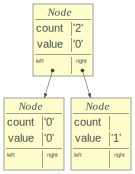

In [11]:
@dataclass
class Node:
    count : int  | None = field(default=None)
    left  : Node | None = field(default=None)
    right : Node | None = field(default=None)
    value : int         = field(init=False)

    def __init__(self, count: int=None, left: Node=None, right: Node=None):
        self.count = count
        self.left  = left
        self.right = right
        if (self.count is None):
            self.value = 1
        else:
            self.value = 0

l_leaf = Node(count=0)
r_leaf = Node(count=None)
head   = Node(count=2, left=l_leaf, right=r_leaf)

treeviz(head)